In [1]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Let's compare and explore a few different loss functions

Code borrowed from a few sources:
- Coursera basic gans
- https://github.com/adambielski/siamese-triplet
- https://github.com/talipucar/PyFlow_SimCLR
- https://github.com/sthalles/SimCLR/blob/master/simclr.py
- https://github.com/wangz10/contrastive_loss

In [114]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
torch.manual_seed(0) # Set for testing purposes, please do not change!





In [3]:
# Params
batch_size = 128
device = 'cpu'

In [4]:
from torchvision.datasets import MNIST
from torchvision import transforms

mean, std = 0.1307, 0.3081

train_dataset = MNIST('./MNIST', train=True, download=True,
                             transform=transforms.Compose([
                                 transforms.ToTensor(),
                                 transforms.Normalize((mean,), (std,))
                             ]))
test_dataset = MNIST('./MNIST', train=False, download=True,
                            transform=transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((mean,), (std,))
                            ]))
n_classes = 10
image_size = 28

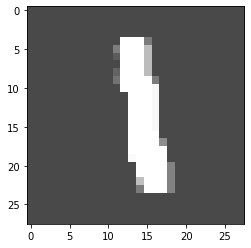

In [38]:
# MNIST
def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()


real = list(train_dataset)[6][0]
show_tensor_images(real)

# Setup

In [110]:
import torch
from torch.optim import lr_scheduler
import torch.optim as optim
from torch.autograd import Variable

from sklearn.decomposition import PCA

import numpy as np
cuda = torch.cuda.is_available()

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

mnist_classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf']

def plot_embeddings(embeddings, targets, xlim=None, ylim=None, hex_bin=False):
    if not hex_bin:
        plt.figure(figsize=(10,10))
        for i in range(10):
            inds = np.where(targets==i)[0]
            plt.scatter(embeddings[inds,0], embeddings[inds,1], alpha=0.5, color=colors[i])
        if xlim:
            plt.xlim(xlim[0], xlim[1])
        if ylim:
            plt.ylim(ylim[0], ylim[1])
        plt.legend(mnist_classes)
    if hex_bin:
        g = sns.jointplot(embeddings[:,0], embeddings[:,1], kind="hex")


def extract_embeddings(dataloader, model):
    with torch.no_grad():
        model.eval()
        embeddings = np.zeros((len(dataloader.dataset), 2))
        labels = np.zeros(len(dataloader.dataset))
        k = 0
        for images, target in dataloader:
            if cuda:
                images = images.cuda()
            embeddings[k:k+len(images)] = model.get_embedding(images).data.cpu().numpy()
            labels[k:k+len(images)] = target.numpy()
            k += len(images)
    return embeddings, labels

# Cross entropy loss

Our first baseline model is a cross entropy loss. 

$$\mathcal{L}_{CE} = \sum^{C}_{i}- y_i log(f_i) $$


In [7]:
# Set up data loaders
batch_size = 256
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

# Set up the network and training parameters
from src.networks import ClassificationNet
from src.metrics import AccumulatedAccuracyMetric

model = ClassificationNet()
if cuda:
    model.cuda()
loss_fn = torch.nn.CrossEntropyLoss()
lr = 1e-2
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 50

In [8]:
from src.trainer import fit
fit(train_loader, test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval, metrics=[AccumulatedAccuracyMetric()])

ERROR:root:No traceback has been produced, nothing to debug.


Train: [0/60000 (0%)]	Loss: 2.416778	Accuracy: 10.9375
Train: [12800/60000 (21%)]	Loss: 1.099815	Accuracy: 56.18106617647059
Train: [25600/60000 (43%)]	Loss: 0.529670	Accuracy: 71.3799504950495
Train: [38400/60000 (64%)]	Loss: 0.356635	Accuracy: 78.24658526490066
Train: [51200/60000 (85%)]	Loss: 0.287181	Accuracy: 81.99043843283582
Epoch: 1/20. Train set: Average loss: 0.5338	Accuracy: 83.65166666666667
Epoch: 1/20. Validation set: Average loss: 0.2302	Accuracy: 95.27
Train: [0/60000 (0%)]	Loss: 0.166399	Accuracy: 96.09375
Train: [12800/60000 (21%)]	Loss: 0.234956	Accuracy: 94.58486519607843
Train: [25600/60000 (43%)]	Loss: 0.197225	Accuracy: 95.01856435643565
Train: [38400/60000 (64%)]	Loss: 0.191011	Accuracy: 95.26334850993378
Train: [51200/60000 (85%)]	Loss: 0.191410	Accuracy: 95.39606654228855
Epoch: 2/20. Train set: Average loss: 0.2003	Accuracy: 95.47833333333334
Epoch: 2/20. Validation set: Average loss: 0.1873	Accuracy: 96.17
Train: [0/60000 (0%)]	Loss: 0.119667	Accuracy: 97.26

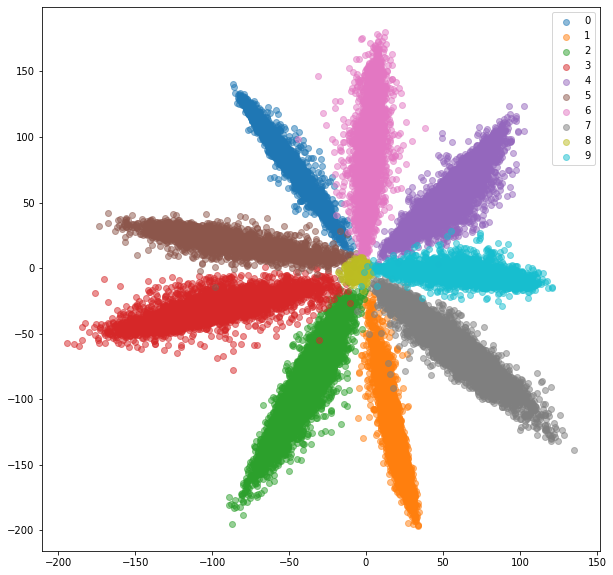

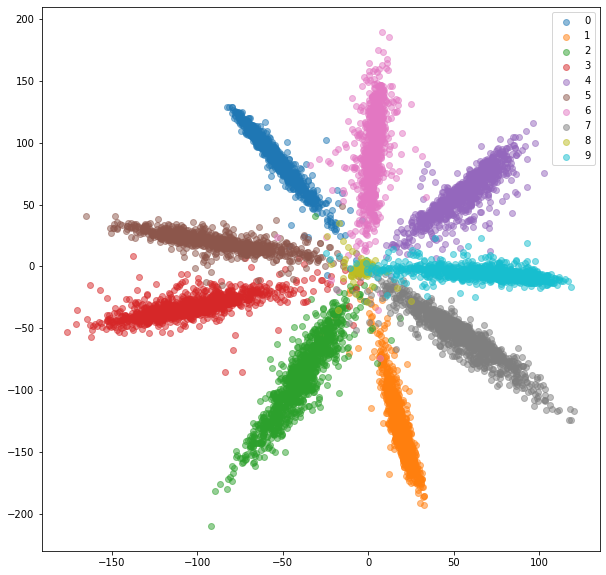

In [14]:
train_embeddings_baseline, train_labels_baseline = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_baseline, train_labels_baseline)
val_embeddings_baseline, val_labels_baseline = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_baseline, val_labels_baseline)

# Autoencoder baseline

Now we will train an autoencoder baseline. An autoencoder consists of two parts; An encoder which finds a compressed representation of an image and a decoder which tries to reconstruct the image based on this compressed representation. The models is trained using a reconstruction loss such as mean squared error. 

$$\mathcal{L}_{MSE}(A, \theta) =\frac{1}{N}\sum_{n=1}^{N} \left \| y_n - f_{\theta}(x_n) \right \|^2_2$$

In the model below we use the same EmbeddingNet network as a encoder but, instead of using the representation to predict class, we use it to reconstruct the image. Note that our representations have not seen the class labels during training.

In [27]:
from src.datasets import AutoencoderMNIST
# Set up data loaders
batch_size = 256
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
autoencoder_train_dataset = AutoencoderMNIST('./MNIST', train=True, download=True,
                             transform=transforms.Compose([
                                 transforms.ToTensor(),
                                 transforms.Normalize((mean,), (std,))
                             ]))
autoencoder_test_dataset = AutoencoderMNIST('./MNIST', train=False, download=True,
                            transform=transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((mean,), (std,))
                            ]))
autoencoder_train_loader = torch.utils.data.DataLoader(autoencoder_train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
autoencoder_test_loader = torch.utils.data.DataLoader(autoencoder_test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

# Set up the network and training parameters
from src.networks import Autoencoder
from src.metrics import AccumulatedAccuracyMetric

model = Autoencoder()
if cuda:
    model.cuda()
loss_fn = nn.MSELoss()
lr = 1e-2
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 50

In [28]:
from src.trainer import fit
fit(autoencoder_train_loader, autoencoder_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)

Train: [0/60000 (0%)]	Loss: 1.313946
Train: [12800/60000 (21%)]	Loss: 0.673138
Train: [25600/60000 (43%)]	Loss: 0.614226
Train: [38400/60000 (64%)]	Loss: 0.598376
Train: [51200/60000 (85%)]	Loss: 0.592661
Epoch: 1/20. Train set: Average loss: 0.6180
Epoch: 1/20. Validation set: Average loss: 0.5911
Train: [0/60000 (0%)]	Loss: 0.586692
Train: [12800/60000 (21%)]	Loss: 0.580603
Train: [25600/60000 (43%)]	Loss: 0.574113
Train: [38400/60000 (64%)]	Loss: 0.570765
Train: [51200/60000 (85%)]	Loss: 0.569072
Epoch: 2/20. Train set: Average loss: 0.5730
Epoch: 2/20. Validation set: Average loss: 0.5695
Train: [0/60000 (0%)]	Loss: 0.609123
Train: [12800/60000 (21%)]	Loss: 0.562672
Train: [25600/60000 (43%)]	Loss: 0.559216
Train: [38400/60000 (64%)]	Loss: 0.557638
Train: [51200/60000 (85%)]	Loss: 0.555874
Epoch: 3/20. Train set: Average loss: 0.5586
Epoch: 3/20. Validation set: Average loss: 0.5548
Train: [0/60000 (0%)]	Loss: 0.565391
Train: [12800/60000 (21%)]	Loss: 0.550036
Train: [25600/60000 (

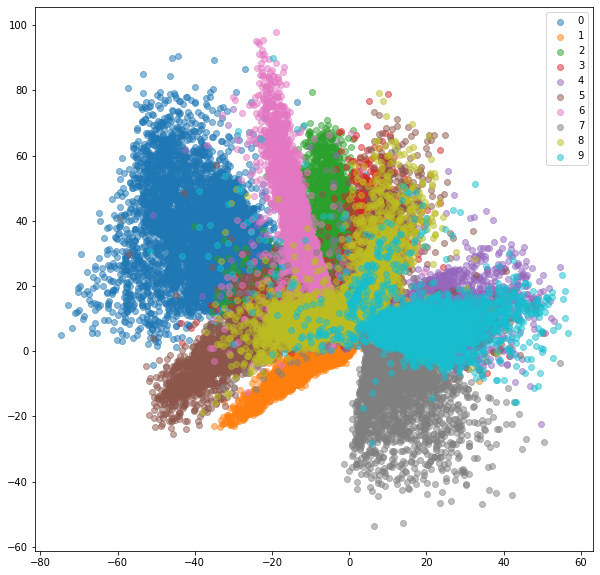

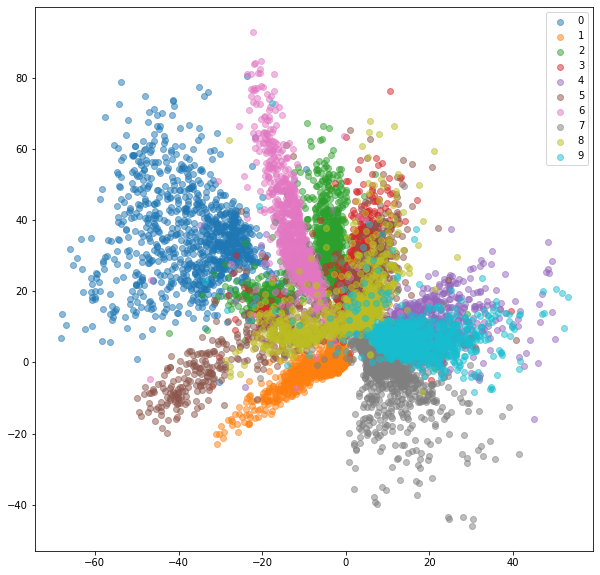

In [29]:
# Use standard loader to get embeddings AND targets
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

train_embeddings_baseline, train_labels_baseline = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_baseline, train_labels_baseline)
val_embeddings_baseline, val_labels_baseline = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_baseline, val_labels_baseline)

# Contrastive loss 

## Siamese network

Now we'll train a siamese network that takes a pair of images and trains the embeddings so that the distance between them is minimized if their from the same class (positive pair) or greater than some margin value if they represent different classes (negative pair)

We'll minimize a contrastive loss function 
$$\mathcal{L}_{contrastive}(x_0, x_1, y) = \frac{1}{2} y \lVert f(x_0)-f(x_1)\rVert_2^2 + \frac{1}{2}(1-y)\{max(0, m-\lVert f(x_0)-f(x_1)\rVert_2)\}^2$$

*Raia Hadsell, Sumit Chopra, Yann LeCun, [Dimensionality reduction by learning an invariant mapping](http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf), CVPR 2006

In [123]:
from src.datasets import SiameseMNIST
from src.losses import ContrastiveLoss
from src.networks import SiameseNet

# Set up data loaders
batch_size = 128
margin =1.0
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}


siamese_train_dataset = SiameseMNIST(train_dataset) # Returns pairs of images and target same/different
siamese_test_dataset = SiameseMNIST(test_dataset)
siamese_train_loader = torch.utils.data.DataLoader(siamese_train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
siamese_test_loader = torch.utils.data.DataLoader(siamese_test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

/home/vauvelle/pycharm-sftp/contrastive/env/lib/python3.7/site-packages/torchvision/datasets/mnist.py:48: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/home/vauvelle/pycharm-sftp/contrastive/env/lib/python3.7/site-packages/torchvision/datasets/mnist.py:58: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/home/vauvelle/pycharm-sftp/contrastive/env/lib/python3.7/site-packages/torchvision/datasets/mnist.py:53: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")
/home/vauvelle/pycharm-sftp/contrastive/env/lib/python3.7/site-packages/torchvision/datasets/mnist.py:63: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")


In [124]:
# Set up the network and training parameters
from src.networks import EmbeddingNet
from src.metrics import AccumulatedAccuracyMetric

model = EmbeddingNet()
model = SiameseNet(model)
loss_fn = ContrastiveLoss(margin)
if cuda:
    model.cuda()
lr = 1e-2
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 10
log_interval = 50

In [125]:
from src.trainer import fit
fit(siamese_train_loader, siamese_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)

Train: [0/60000 (0%)]	Loss: 0.228211
Train: [6400/60000 (11%)]	Loss: 0.090512
Train: [12800/60000 (21%)]	Loss: 0.063120
Train: [19200/60000 (32%)]	Loss: 0.050590
Train: [25600/60000 (43%)]	Loss: 0.046581
Train: [32000/60000 (53%)]	Loss: 0.044366
Train: [38400/60000 (64%)]	Loss: 0.036473
Train: [44800/60000 (75%)]	Loss: 0.036210
Train: [51200/60000 (85%)]	Loss: 0.035972
Train: [57600/60000 (96%)]	Loss: 0.032833
Epoch: 1/10. Train set: Average loss: 0.0481
Epoch: 1/10. Validation set: Average loss: 0.0291
Train: [0/60000 (0%)]	Loss: 0.039463
Train: [6400/60000 (11%)]	Loss: 0.030238
Train: [12800/60000 (21%)]	Loss: 0.030961
Train: [19200/60000 (32%)]	Loss: 0.031910
Train: [25600/60000 (43%)]	Loss: 0.029229
Train: [32000/60000 (53%)]	Loss: 0.027031
Train: [38400/60000 (64%)]	Loss: 0.025532
Train: [44800/60000 (75%)]	Loss: 0.027515
Train: [51200/60000 (85%)]	Loss: 0.026091
Train: [57600/60000 (96%)]	Loss: 0.025692
Epoch: 2/10. Train set: Average loss: 0.0280
Epoch: 2/10. Validation set: Ave

/home/vauvelle/pycharm-sftp/contrastive/env/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/vauvelle/pycharm-sftp/contrastive/env/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


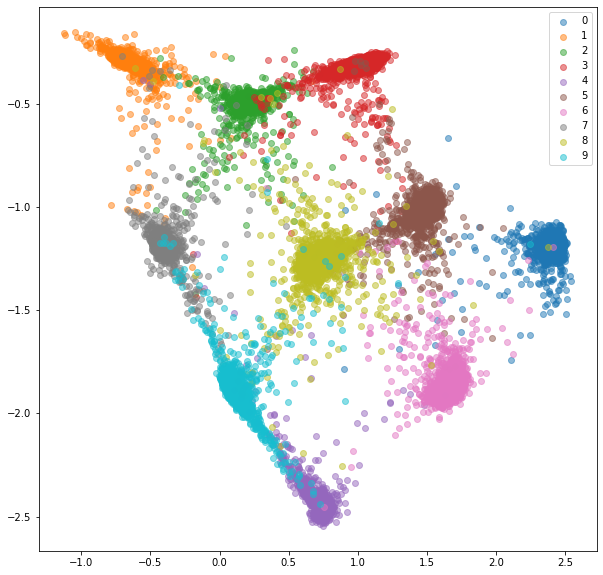

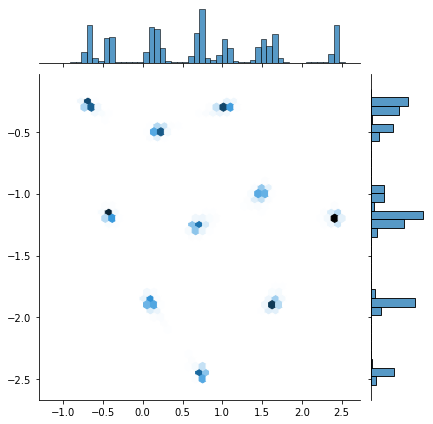

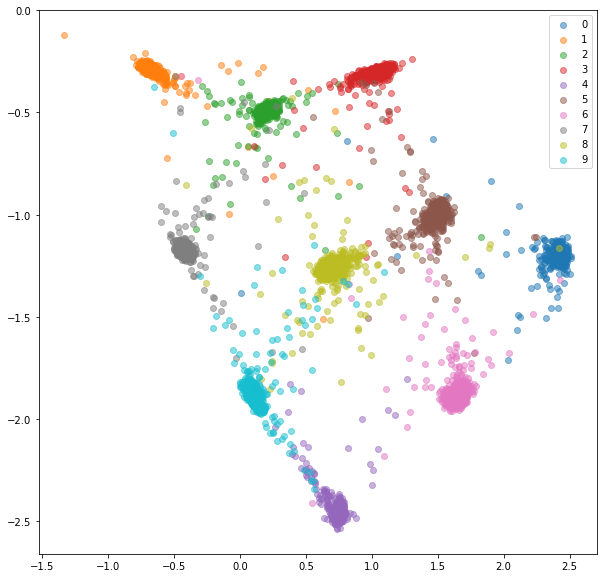

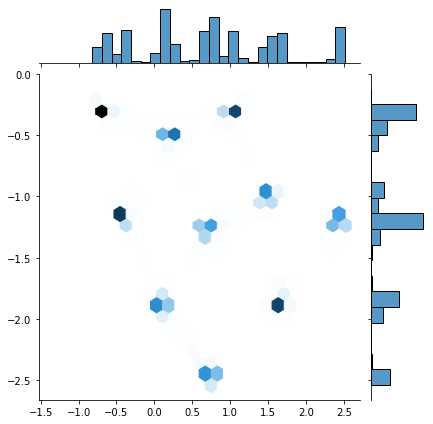

In [128]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, **kwargs)
train_embeddings_con, train_labels_con = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_con, train_labels_con)
plot_embeddings(train_embeddings_con, train_labels_con, hex_bin=True)
val_embeddings_con, val_labels_con = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_con, val_labels_con)
plot_embeddings(val_embeddings_con, val_labels_con, hex_bin=True)

## NTXentLoss


Instead of using the image labels to form a positive pair we can instead augment an image and form positive pairs from a single instance. Negative pairs can be be found by comparing with augmented images from a different instance. This is the key idea behind SiCLR: https://arxiv.org/pdf/2002.05709.pdf

The loss is

$$\mathcal{L}_q = - log\frac{exp(sim( z_i \cdot z_j) / \tau)}{\sum^{2N}_{i=1}\mathbb{1}_{[k\neq i]}exp(sim (z_i \cdot z_k) / \tau)}$$

where N is the number of samples in the mini-batch, z is a latent representation from the encoder and sim is a similarity function such as cosine similarity.

Note how negative pairs are not explicity sampled. Rather, the other augmented samples within a batch are used as negatives for a pair. This is shown in the denominator where 2(N-1) samples from other pairs are used.

Expanding a bit we can get

$$\mathcal{L}_q = - log(exp(sim( z_i \cdot z_j) / \tau)) + log(\sum^{2N}_{i=1}\mathbb{1}_{[k\neq i]}exp(sim (z_i \cdot z_k) / \tau))$$


$$\mathcal{L}_q = - log(exp(sim( z_i \cdot z_j) / \tau)) + log(\sum^{2N}_{i=1}\mathbb{1}_{[k\neq i]}exp(sim (z_i \cdot z_k) / \tau))$$

$$\mathcal{L}_q = - sim( z_i \cdot z_j) / \tau + log(\sum^{2N}_{i=1}\mathbb{1}_{[k\neq i]}exp(sim (z_i \cdot z_k) / \tau))$$

Two vectors that are perfectly aligned will have cosine similarity of 1, if 90 degrees the value will be 0 and if opposite the value will be -1. 

In [22]:
x_1 = torch.tensor([0,2]).float()
x_2 = torch.tensor([2,0]).float()
x_3 = torch.tensor([0,-9]).float()

cos = torch.nn.CosineSimilarity(dim=-1)

print('Pair at aligned: x_1= (0,1) , x_1= (0, 1). cos(x_1, x_2): {}'.format(cos(x_1, x_1)))
print('Pair at right angles: x_1= (0,1) , x_2= (1, 0). cos(x_1, x_2): {}'.format(cos(x_1, x_2)))
print('Pair opposite: x_1= (0,1) , x_2= (1, 0). cos(x_1, x_2): {}'.format(cos(x_1, x_3)))

Pair at aligned: x_1= (0,1) , x_1= (0, 1). cos(x_1, x_2): 1.0
Pair at right angles: x_1= (0,1) , x_2= (1, 0). cos(x_1, x_2): 0.0
Pair opposite: x_1= (0,1) , x_2= (1, 0). cos(x_1, x_2): -1.0


From this we can see that the $-sim(z_i \cdot z_j)/ \tau$ terms will reduce the loss if positive pairs are closer together (attract) and that the second term will reduce the loss if negative pairs are further apart (repel). This is demonstrated in the below gif.

![SimCLR](./images/simclr.gif)

First lets check our NTXentLoss is working without augmentations and instead form pairs with class labels

In [129]:
from src.datasets import SimCLRMNIST
from src.losses import ContrastiveLoss
from src.networks import SiameseNet

# Set up data loaders
batch_size = 32
margin =1.0
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}


train_transform = transforms.Compose([
            transforms.RandomResizedCrop(size=image_size, scale=(0.5, 1.0), ratio=(0.75, 1.3333333333333333)),
#             transforms.RandomHorizontalFlip(), doesn't make sense for mnist
#             transforms.RandomApply([color_jitter], p=0.8),
#             transforms.RandomGrayscale(p=0.2),
            transforms.ToTensor(),
        ])


siamese_train_dataset = SiameseMNIST(train_dataset) # Returns pairs of images and target same/different
siamese_test_dataset = SiameseMNIST(test_dataset)
simclr_train_loader  = torch.utils.data.DataLoader(siamese_train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
simclr_test_loader = torch.utils.data.DataLoader(siamese_test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

/home/vauvelle/pycharm-sftp/contrastive/env/lib/python3.7/site-packages/torchvision/datasets/mnist.py:48: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/home/vauvelle/pycharm-sftp/contrastive/env/lib/python3.7/site-packages/torchvision/datasets/mnist.py:58: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/home/vauvelle/pycharm-sftp/contrastive/env/lib/python3.7/site-packages/torchvision/datasets/mnist.py:53: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")
/home/vauvelle/pycharm-sftp/contrastive/env/lib/python3.7/site-packages/torchvision/datasets/mnist.py:63: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")


In [130]:
# Set up the network and training parameters
from src.networks import EmbeddingNet, SimCLRNet
from src.metrics import AccumulatedAccuracyMetric
from src.losses import NTXentLoss

model = EmbeddingNet()
model = SimCLRNet(model)
options = {
    'tau':1,
    'batch_size': batch_size,
    'device': device,
    'cosine_similarity': True
}
loss_fn = NTXentLoss(options)
if cuda:
    model.cuda()
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 100

In [131]:
# %debug
from src.trainer import fit
fit(simclr_train_loader, simclr_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)

Train: [0/60000 (0%)]	Loss: 4.138772
Train: [3200/60000 (5%)]	Loss: 4.097176
Train: [6400/60000 (11%)]	Loss: 4.069286
Train: [9600/60000 (16%)]	Loss: 4.061793
Train: [12800/60000 (21%)]	Loss: 4.073260
Train: [16000/60000 (27%)]	Loss: 4.035980
Train: [19200/60000 (32%)]	Loss: 4.036787
Train: [22400/60000 (37%)]	Loss: 4.035830
Train: [25600/60000 (43%)]	Loss: 4.014536
Train: [28800/60000 (48%)]	Loss: 4.028061
Train: [32000/60000 (53%)]	Loss: 4.036704
Train: [35200/60000 (59%)]	Loss: 4.010603
Train: [38400/60000 (64%)]	Loss: 4.023294
Train: [41600/60000 (69%)]	Loss: 3.997745
Train: [44800/60000 (75%)]	Loss: 3.989825
Train: [48000/60000 (80%)]	Loss: 3.991607
Train: [51200/60000 (85%)]	Loss: 4.005683
Train: [54400/60000 (91%)]	Loss: 3.966549
Train: [57600/60000 (96%)]	Loss: 3.984791
Epoch: 1/20. Train set: Average loss: 4.0245
Epoch: 1/20. Validation set: Average loss: 3.9986
Train: [0/60000 (0%)]	Loss: 3.974407
Train: [3200/60000 (5%)]	Loss: 4.003727
Train: [6400/60000 (11%)]	Loss: 3.97802

/home/vauvelle/pycharm-sftp/contrastive/env/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/vauvelle/pycharm-sftp/contrastive/env/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


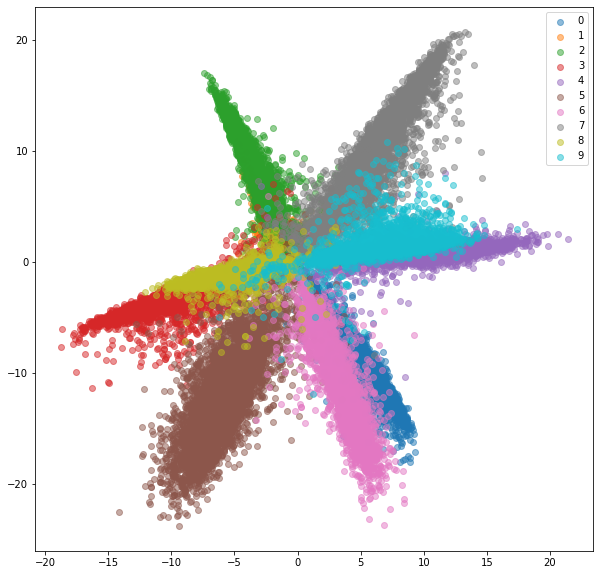

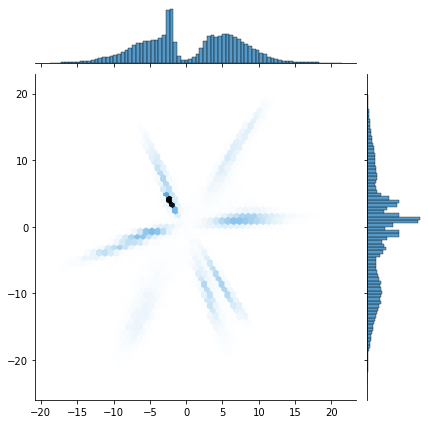

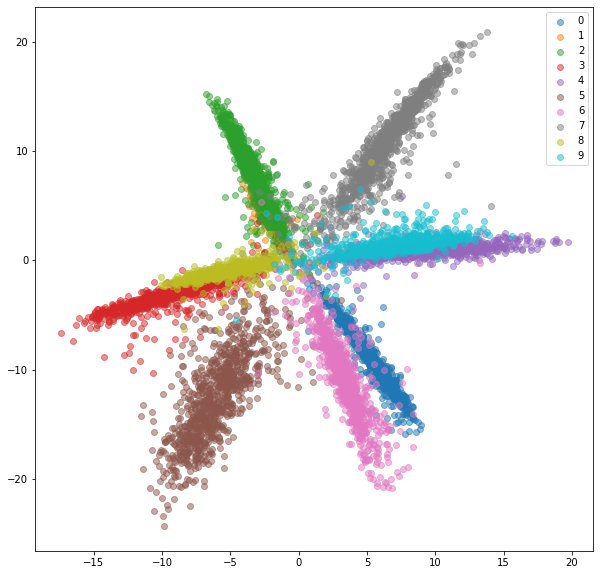

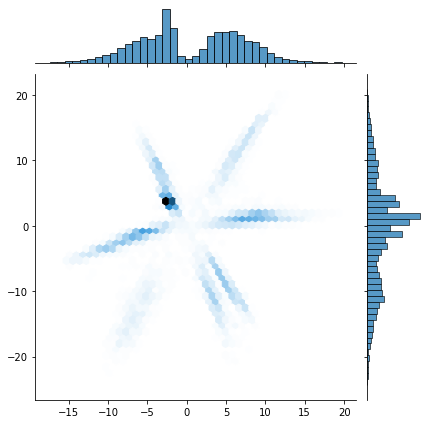

In [132]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, **kwargs)
train_embeddings_simclr, train_labels_simclr = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_simclr, train_labels_simclr)
plot_embeddings(train_embeddings_simclr, train_labels_simclr, hex_bin=True)
val_embeddings_simclr, val_labels_simclr = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_simclr, val_labels_simclr)
plot_embeddings(val_embeddings_simclr, val_labels_simclr, hex_bin=True)

Now let's try with data augmentations.

Lets first take a look a look at the augmented images to see if the croping is making much sense

In [63]:
simclr_train_dataset = SimCLRMNIST(train_dataset, transform=train_transform) # Returns pairs of images and target same/different
simclr_test_dataset = SimCLRMNIST(test_dataset)
simclr_train_loader = torch.utils.data.DataLoader(simclr_train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
simclr_test_loader = torch.utils.data.DataLoader(simclr_test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

simclr_list = list(simclr_train_dataset)


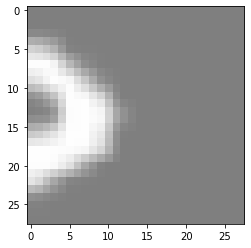

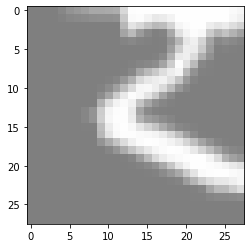

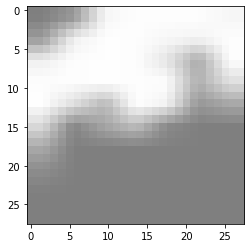

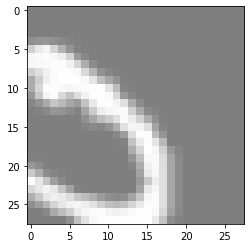

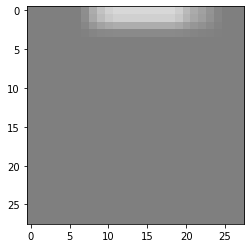

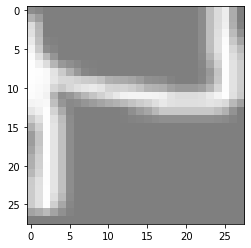

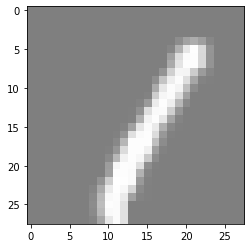

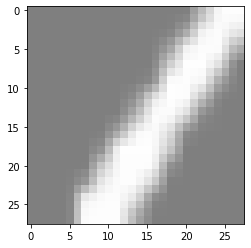

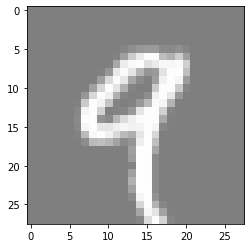

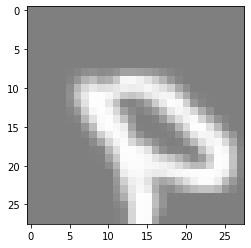

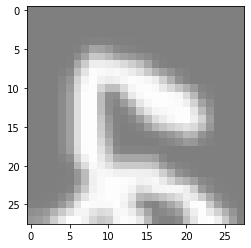

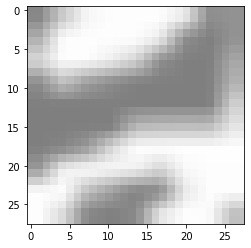

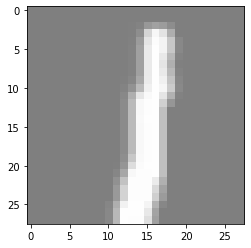

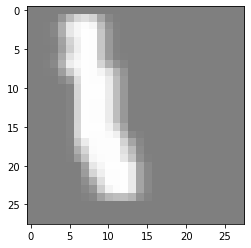

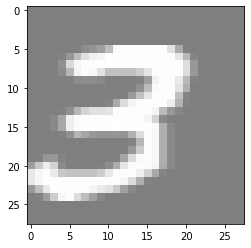

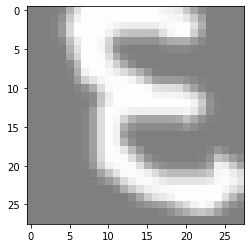

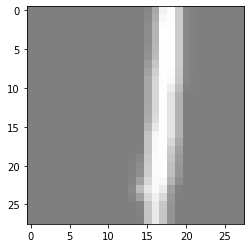

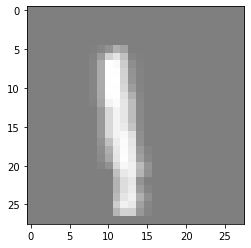

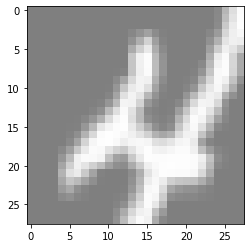

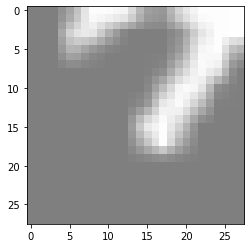

In [75]:
for n in range(10):
    real = simclr_list[n][0]
    show_tensor_images(real[0])
    show_tensor_images(real[1])

Clearly with MNIST, flipping and cropping don't ways make sense... Lets try anyway

In [76]:
# Set up the network and training parameters
from src.networks import EmbeddingNet, SimCLRNet
from src.metrics import AccumulatedAccuracyMetric
from src.losses import NTXentLoss

model = EmbeddingNet()
model = SimCLRNet(model)
options = {
    'tau':1,
    'batch_size': batch_size,
    'device': device,
    'cosine_similarity': True
}
loss_fn = NTXentLoss(options)
if cuda:
    model.cuda()
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 100

In [77]:
# %debug
from src.trainer import fit
fit(simclr_train_loader, simclr_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)

Train: [0/60000 (0%)]	Loss: 5.531734
Train: [12800/60000 (21%)]	Loss: 5.325044
Train: [25600/60000 (43%)]	Loss: 5.167320
Train: [38400/60000 (64%)]	Loss: 5.099562
Train: [51200/60000 (85%)]	Loss: 5.068194
Epoch: 1/20. Train set: Average loss: 5.1494
Epoch: 1/20. Validation set: Average loss: 5.5146
Train: [0/60000 (0%)]	Loss: 5.049723
Train: [12800/60000 (21%)]	Loss: 5.045543
Train: [25600/60000 (43%)]	Loss: 5.040933
Train: [38400/60000 (64%)]	Loss: 5.036757
Train: [51200/60000 (85%)]	Loss: 5.039019
Epoch: 2/20. Train set: Average loss: 5.0388
Epoch: 2/20. Validation set: Average loss: 5.5145
Train: [0/60000 (0%)]	Loss: 5.034476
Train: [12800/60000 (21%)]	Loss: 5.033634
Train: [25600/60000 (43%)]	Loss: 5.022962
Train: [38400/60000 (64%)]	Loss: 5.028581
Train: [51200/60000 (85%)]	Loss: 5.016192
Epoch: 3/20. Train set: Average loss: 5.0245
Epoch: 3/20. Validation set: Average loss: 5.5146
Train: [0/60000 (0%)]	Loss: 5.017509
Train: [12800/60000 (21%)]	Loss: 5.026476
Train: [25600/60000 (

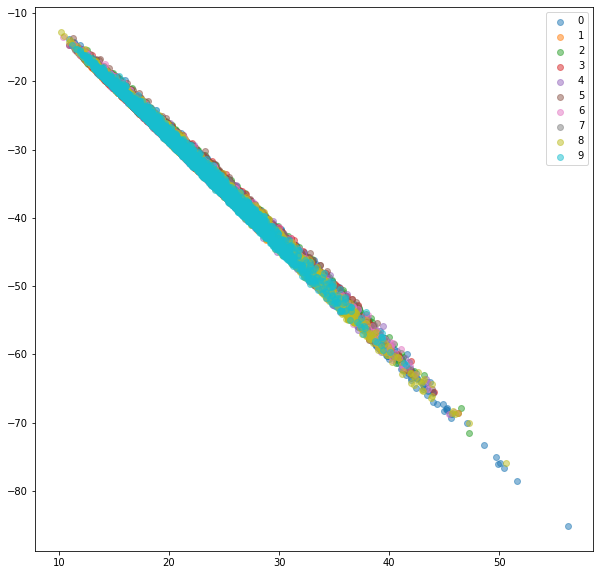

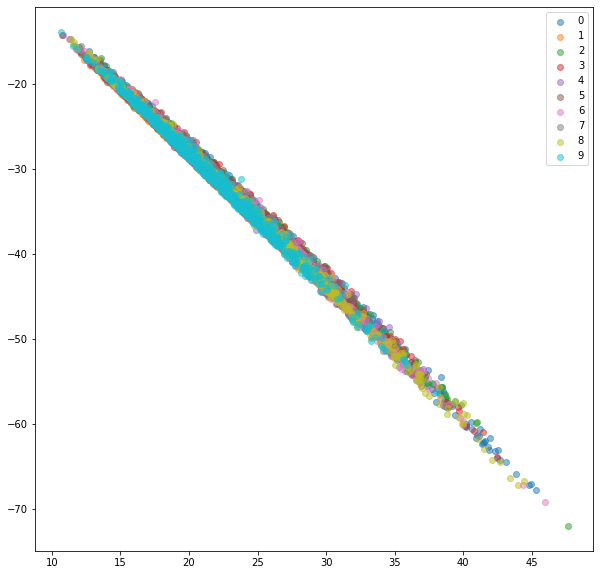

In [78]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, **kwargs)
train_embeddings_simclr, train_labels_simclr = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_simclr, train_labels_simclr)
val_embeddings_simclr, val_labels_simclr = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_simclr, val_labels_simclr)

Didn't learn much...


Let's also try on the fashion mnist dataset

In [92]:
from torchvision.datasets import FashionMNIST
from torchvision import transforms

mean, std = 0.1307, 0.3081

train_dataset_fashion = FashionMNIST('./FashionMNIST', train=True, download=True,
                             transform=transforms.Compose([
                                 transforms.ToTensor(),
                                 transforms.Normalize((mean,), (std,))
                             ]))
test_dataset_fashion = FashionMNIST('./FashionMNIST', train=False, download=True,
                            transform=transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((mean,), (std,))
                            ]))
n_classes = 10
image_size = 28

In [105]:
train_transform = transforms.Compose([
            transforms.RandomResizedCrop(size=image_size, scale=(0.7, 1), ratio=(0.25, 4)),
            transforms.RandomHorizontalFlip(),
#             transforms.RandomApply([color_jitter], p=0.8),
            transforms.RandomGrayscale(p=0.2),
            transforms.ToTensor(),
        ])

simclr_train_dataset = SimCLRMNIST(train_dataset_fashion, transform=train_transform) # Returns pairs of images and target same/different
simclr_test_dataset = SimCLRMNIST(test_dataset_fashion)
simclr_train_loader = torch.utils.data.DataLoader(simclr_train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
simclr_test_loader = torch.utils.data.DataLoader(simclr_test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

simclr_list = list(simclr_train_dataset)


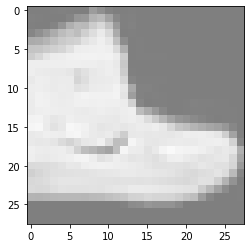

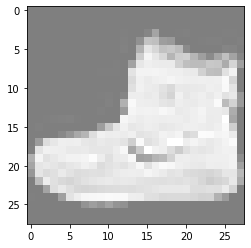

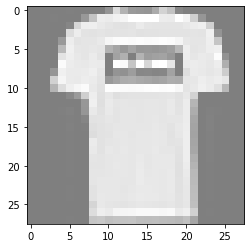

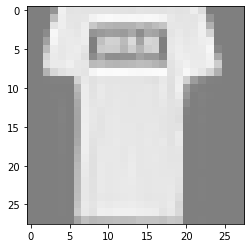

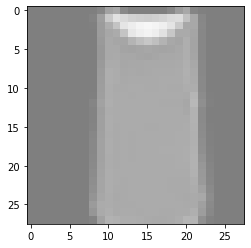

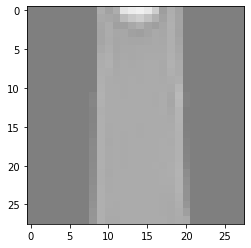

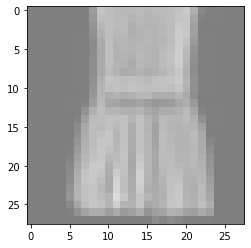

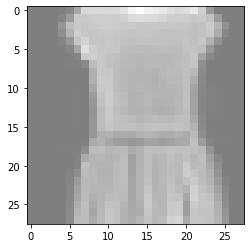

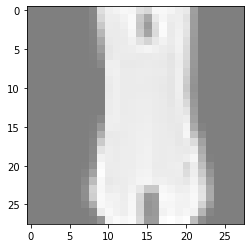

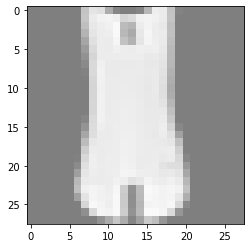

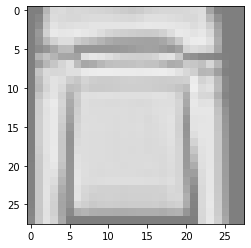

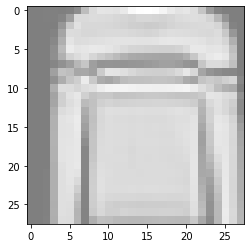

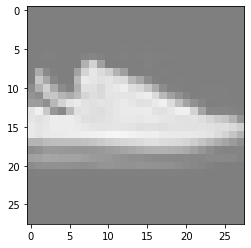

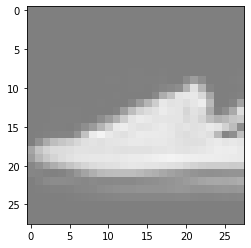

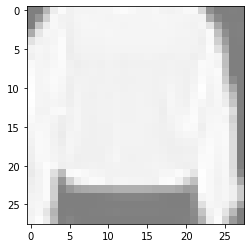

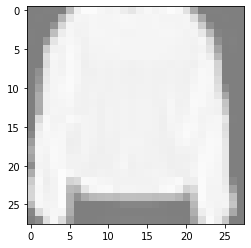

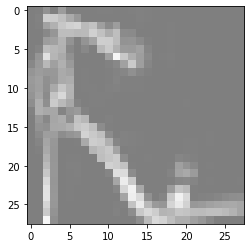

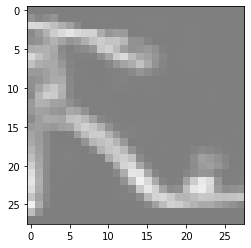

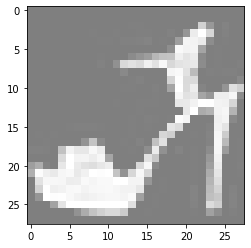

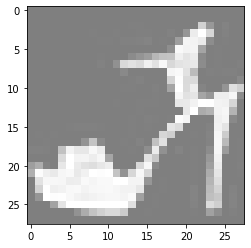

In [106]:
for n in range(10):
    real = simclr_list[n][0]
    show_tensor_images(real[0])
    show_tensor_images(real[1])

In [120]:
# Set up the network and training parameters
from src.networks import EmbeddingNet, SimCLRNet
from src.metrics import AccumulatedAccuracyMetric
from src.losses import NTXentLoss

model = EmbeddingNet()
model = SimCLRNet(model)
options = {
    'tau':0.5,
    'batch_size': batch_size,
    'device': device,
    'cosine_similarity': True
}
loss_fn = NTXentLoss(options)
if cuda:
    model.cuda()
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 100

In [121]:
# %debug
from src.trainer import fit
fit(simclr_train_loader, simclr_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)

Train: [0/60000 (0%)]	Loss: 4.158033
Train: [3200/60000 (5%)]	Loss: 3.127060
Train: [6400/60000 (11%)]	Loss: 3.038115
Train: [9600/60000 (16%)]	Loss: 3.028296
Train: [12800/60000 (21%)]	Loss: 3.020008
Train: [16000/60000 (27%)]	Loss: 3.009933
Train: [19200/60000 (32%)]	Loss: 3.009945
Train: [22400/60000 (37%)]	Loss: 3.007781
Train: [25600/60000 (43%)]	Loss: 3.015285
Train: [28800/60000 (48%)]	Loss: 3.005630
Train: [32000/60000 (53%)]	Loss: 3.002218
Train: [35200/60000 (59%)]	Loss: 3.019300
Train: [38400/60000 (64%)]	Loss: 3.005547
Train: [41600/60000 (69%)]	Loss: 3.004313
Train: [44800/60000 (75%)]	Loss: 3.001343
Train: [48000/60000 (80%)]	Loss: 3.001559
Train: [51200/60000 (85%)]	Loss: 3.003570
Train: [54400/60000 (91%)]	Loss: 3.006861
Train: [57600/60000 (96%)]	Loss: 3.006561
Epoch: 1/20. Train set: Average loss: 3.0174
Epoch: 1/20. Validation set: Average loss: 3.7498
Train: [0/60000 (0%)]	Loss: 3.007063
Train: [3200/60000 (5%)]	Loss: 3.000207
Train: [6400/60000 (11%)]	Loss: 3.00619

/home/vauvelle/pycharm-sftp/contrastive/env/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/vauvelle/pycharm-sftp/contrastive/env/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


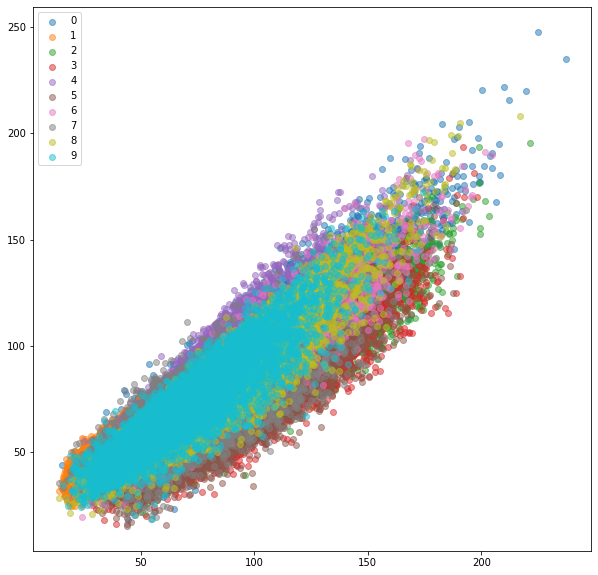

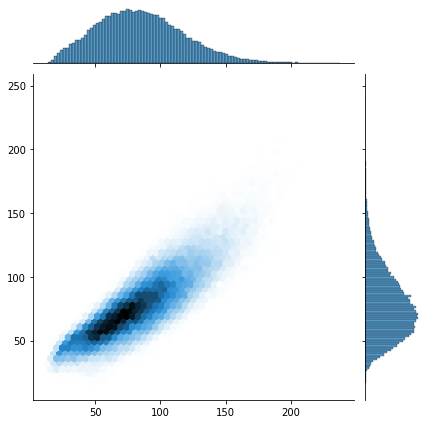

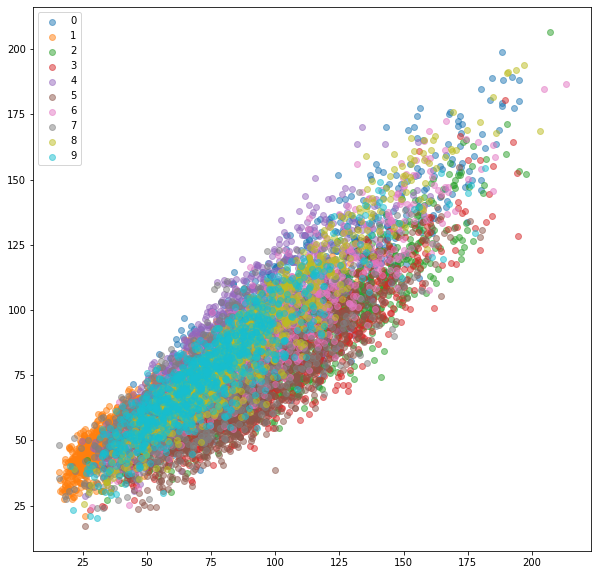

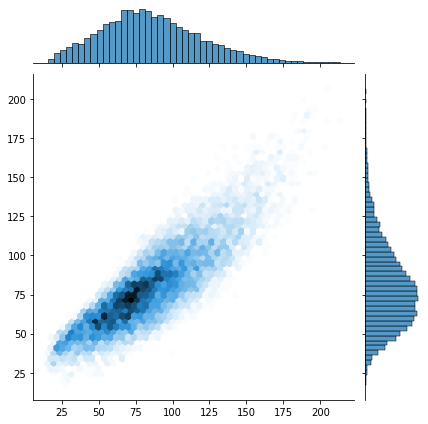

In [122]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, **kwargs)
train_embeddings_simclr, train_labels_simclr = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_simclr, train_labels_simclr)
plot_embeddings(train_embeddings_simclr, train_labels_simclr, hex_bin=True)
val_embeddings_simclr, val_labels_simclr = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_simclr, val_labels_simclr)
plot_embeddings(val_embeddings_simclr, val_labels_simclr, hex_bin=True)